## Aim to characterize behaviours of credit card users.
- purpose is to design targeted card incentives.
- Separated users to 4 categories based on user habits using principal component analysis.
- Type1 (30% user): purchase-driven and suitable for incentives such as 50k reward points after spending 3 grants in the first month;
- Type2 (23% user): cash-driven and suitable for incentives in cash advance
- Type3 (10% user): installment-driven and suitable for incentives in 0% purchase APR

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
home = os.getcwd()
dir = os.path.dirname(home) #"data_challenge_5" folder

data = pd.read_csv(os.path.join(dir,r'cc_info.csv'), header = 0,parse_dates = True)

In [2]:
profile = pandas_profiling.ProfileReport(data)
display(profile)

#### Impute missing values using MICE (Multiple Imputation by Chained Equations)

In [2]:
from impyute.imputation.cs import mice

# first, remove the "CUST_ID" column since it's not informative
data.drop (columns = 'CUST_ID', inplace = True)

# impute values to an output of 2D array and convert back to df
impdata = pd.DataFrame (mice(data.values), columns = data.columns) 

In [3]:
# confirm na removal
print ("Data has {} missing values.".format(sum(impdata.isnull().sum())))

Data has 0 missing values.


### PCA to see how users cluster and by which feastures.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Scale features using standard scaler and perform PCA
pca = PCA()
std_clf = make_pipeline(StandardScaler(), pca)
x_new = std_clf.fit_transform(impdata)

# Plot top 2 PCs
def myplot(score, loading, color = 'c',labels=None, percent_exp=None):
    xs = score[:,0]
    ys = score[:,1]
    n = loading.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = color, alpha = 0.3)
    for i in range(n):
        plt.arrow(0, 0, loading[i,0]*1.5, loading[i,1]*1.5,color = 'r',alpha = 1, shape = 'full')
        if labels is None:
            plt.text(loading[i,0]* 1.15, loading[i,1] * 1.15, "V"+str(i+1), 
                     color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(loading[i,0]* 1.8, loading[i,1] * 1.8, labels[i], 
                     color = 'k', ha = 'center', va = 'center', fontsize=15)
    plt.xlim(-0.5,1)
    plt.ylim(-0.5,1)
    plt.xlabel("PC{} ".format(1) + "(" + '{:.0f}'.format(percent_exp[0]*100) + "%)", fontsize=15)
    plt.ylabel("PC{} ".format(2) + "(" + '{:.0f}'.format(percent_exp[1]*100) + "%)", fontsize=15)
    plt.grid()

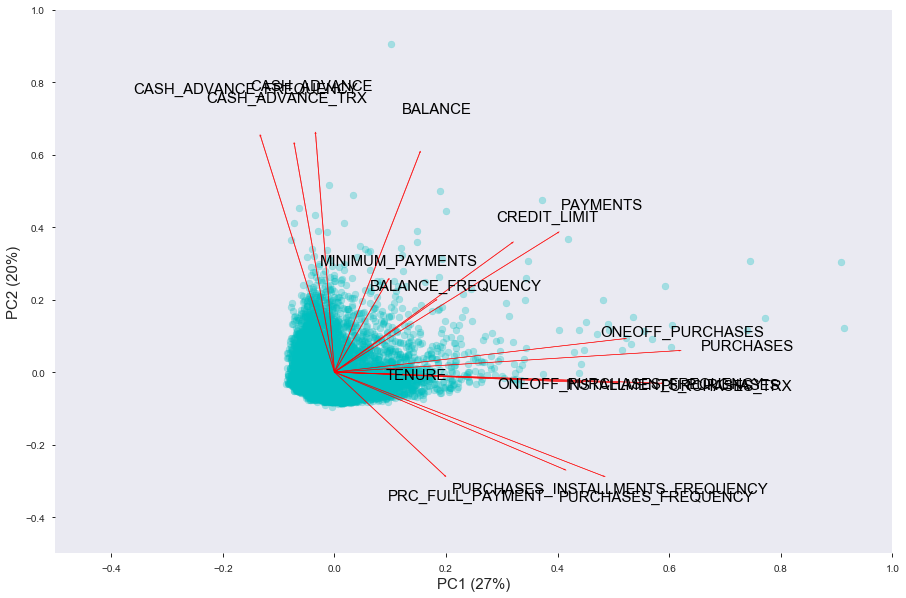

In [5]:
#Call the function. Use only the 2 PCs.
plt.figure(figsize=(15, 10))

myplot(score = x_new[:,0:2],
       loading = np.transpose(pca.components_[0:2, :]),
       percent_exp = pca.explained_variance_ratio_[:2],
       labels = impdata.columns
      )
plt.show()

In [6]:
# List out top 5 PC ordered by var%
pca.explained_variance_ratio_ [:5]

array([0.27300749, 0.20319834, 0.08828993, 0.07487455, 0.06204475])

- Top 2 PC explain 27% and 20% of variance, while third and fourth PCs explains 9% and 7%.

In [7]:
# List loadings for top4 PCs to understand how each feature is weighted
loadings = pd.DataFrame (np.transpose(pca.components_[0:4, :]), index = impdata.columns, 
                         columns = ['pc1', 'pc2', 'pc3', 'pc4'])
loadings

,pc1,pc2,pc3,pc4
BALANCE,0.102051,0.403929,-0.163657,0.276846
BALANCE_FREQUENCY,0.120700,0.131761,-0.423879,0.154322
PURCHASES,0.411527,0.039579,0.256792,0.044679
ONEOFF_PURCHASES,0.346304,0.061495,0.389585,0.090766
INSTALLMENTS_PURCHASES,0.336733,-0.019452,-0.108466,-0.061131
CASH_ADVANCE,-0.022585,0.438909,-0.019875,-0.257487
PURCHASES_FREQUENCY,0.321144,-0.191212,-0.368935,-0.198801
ONEOFF_PURCHASES_FREQUENCY,0.294441,-0.018821,0.115747,0.037466
PURCHASES_INSTALLMENTS_FREQUENCY,0.274422,-0.178893,-0.466727,-0.231944
CASH_ADVANCE_FREQUENCY,-0.088347,0.434112,-0.101219,-0.265401


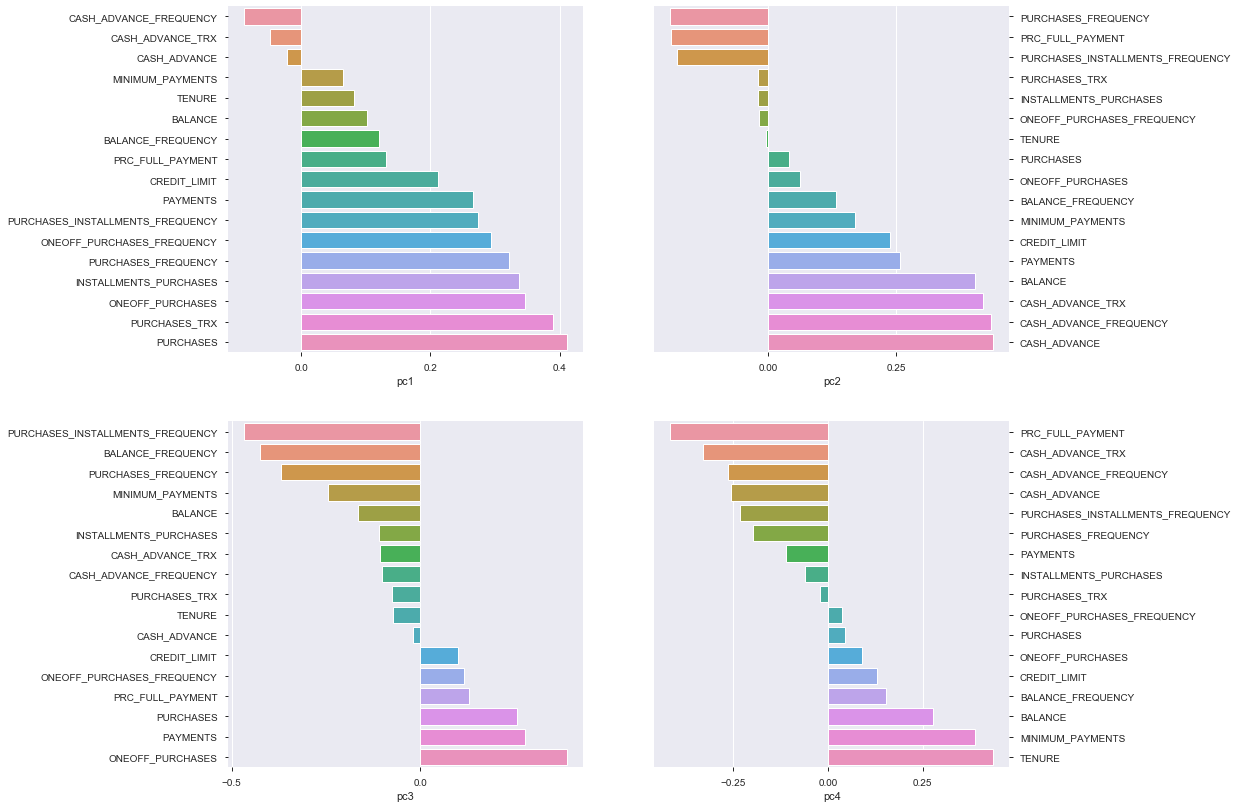

In [8]:
# Plot importance

# set up subplots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(14, 14))

# adjust font size
sns.set(font_scale = 3)

# plot pc1
sns.barplot (x = loadings.sort_values(['pc1'])['pc1'], y = loadings.sort_values(['pc1']).index, ax = axs[0,0] )

# plot pc2 with yticks on the right
sns.barplot (x = loadings.sort_values(['pc2'])['pc2'], y = loadings.sort_values(['pc2']).index, ax = axs[0,1] )
axs[0,1].yaxis.tick_right()

# plot pc3
sns.barplot (x = loadings.sort_values(['pc3'])['pc3'], y = loadings.sort_values(['pc3']).index, ax = axs[1,0] )

# plot pc4 with yticks on the right
sns.barplot (x = loadings.sort_values(['pc4'])['pc4'], y = loadings.sort_values(['pc4']).index, ax = axs[1,1] )
axs[1,1].yaxis.tick_right()

- pc1 helps to distinguish users who are purchase-driven.
- pc2 helps to distinguish users who are cash-advance driven.
- pc3 helps to distinguish users who are balance-driven and prefer installments.
- pc4 seems to provide redundant insights as pc1-3.

## Label users by pca scores

In [9]:
# gather pc sores
scores = pd.DataFrame(x_new[:,0:4], columns = ["Score_"+str(i) for i in range(1,5)])

In [10]:
# label type_1 customer based on pc1 score being top 30%.
s = np.percentile(np.array(scores['Score_1']), 70)
type1 = ["Type1" if x > s else "Others" for x in scores['Score_1']]

# label type_2 customer based on pc2 score being top 30%.
s = np.percentile(np.array(scores['Score_2']), 70)
type2 = ["Type2" if x > s else "Others" for x in scores['Score_2']]

# label type_3 customer based on pc3 score being bottom 30%.
s = np.percentile(np.array(scores['Score_3']), 30)
type3 = ["Type3" if x < s else "Others" for x in scores['Score_3']]

# combine 3 labels with desceding priotity type1 > type2 > type3
usertype = pd.DataFrame({"t1":type1,
                         "t2":type2,
                         "t3":type3
                        }).apply(lambda x:
                                 ["Type1","Type2","Type3","Others"][min(
                                     ["Type1","Type2","Type3","Others"].index(x[0]),
                                     ["Type1","Type2","Type3","Others"].index(x[1]),
                                     ["Type1","Type2","Type3","Others"].index(x[2]),
                                 )],
                                 axis = 1                            
                        )


Others    0.364581
Type1     0.300000
Type2     0.231061
Type3     0.104358
dtype: float64


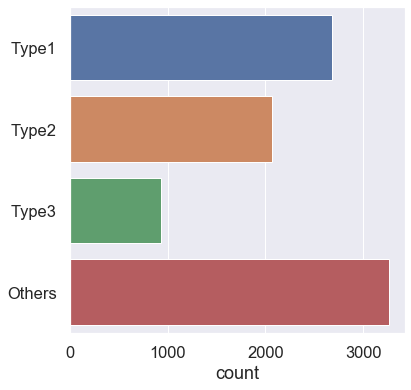

In [11]:
# Plot users separated by type
sns.set(font_scale=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("notebook", font_scale=1.5)
ax = sns.countplot(y=usertype, order = ["Type1","Type2","Type3","Others"])
print(usertype.value_counts()/usertype.shape)

In [12]:
usertype.value_counts()

Others    3263
Type1     2685
Type2     2068
Type3      934
dtype: int64

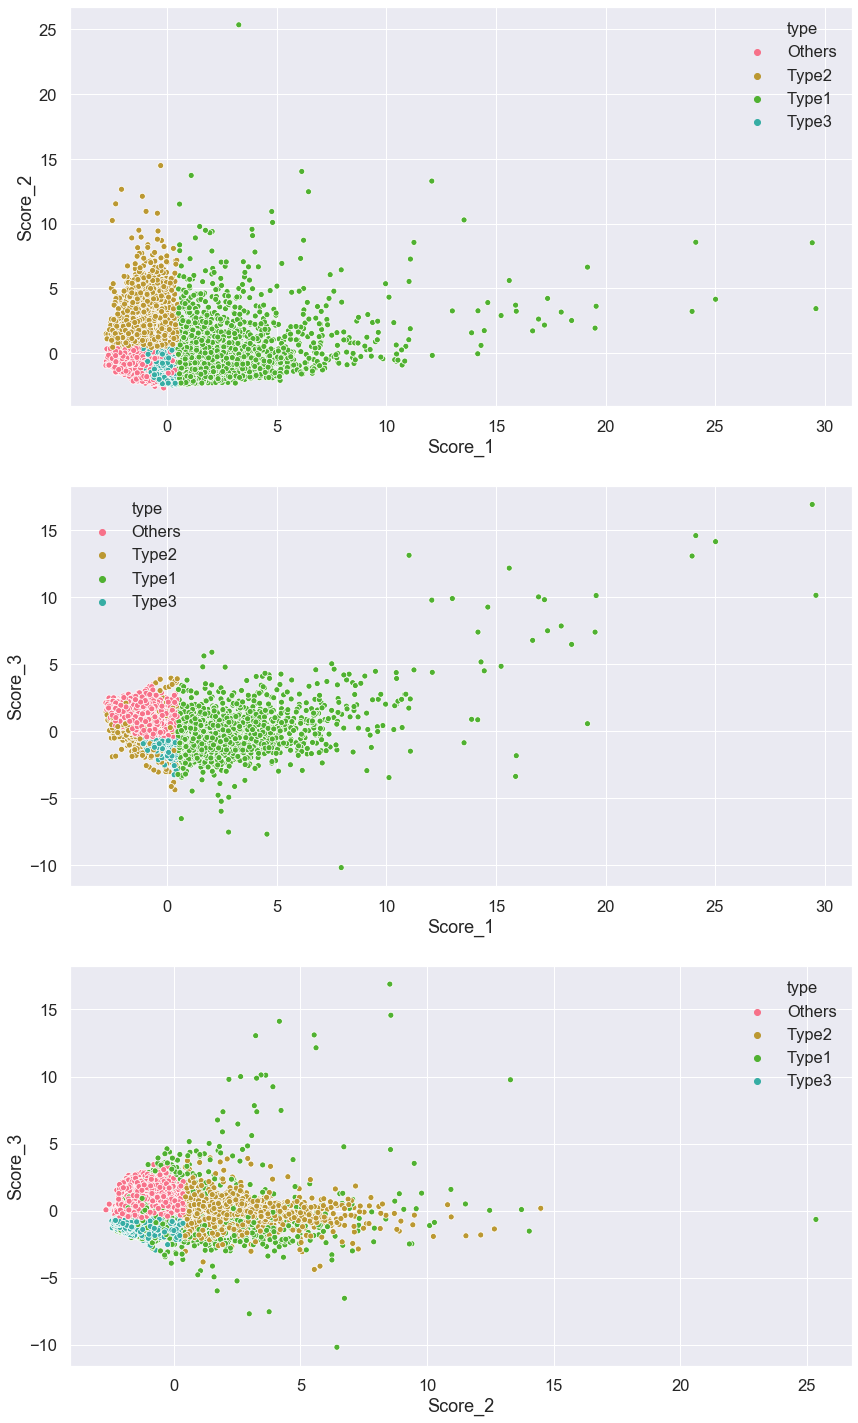

In [13]:
# Plot pca scores again and show user labels
scores['type'] = usertype
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(14, 25))

sns.set(style = 'dark', palette="husl", color_codes=True,font_scale=1.5)

sns.scatterplot ( x = 'Score_1', y = 'Score_2', data = scores, hue = 'type' , alpha = 1, ax = axs[0])
sns.scatterplot ( x = 'Score_1', y = 'Score_3', data = scores, hue = 'type' , alpha = 1, ax = axs[1])
sns.scatterplot ( x = 'Score_2', y = 'Score_3', data = scores, hue = 'type' , alpha = 1, ax = axs[2])